# Landau Damping

### Physical Picture

Landau damping is a phenomenon that occurs in warm plasmas when particles exchange energy with a wave.

In a warm plasma, the particles' velocity is distributed according to a maxwellian distribution, however, only the ones whose velocity is close to the phase speed of the wave will interact signifincantly though a mechanism called "trapping", described thorougly in J. D. Jackson [1].

This mechanism can be easily understood through an analogy with surfers in the sea depicted in the
image below:

<img src="drawing.png" width="800">

Both sufers are traveling at speeds close to the wave's speed, hoever, the right surfer's speed is smaller than the wave's speed, and the left surfer's speed is bigger thant the wave's speed.

This way, the right surfer gets caught and pushed by the wave, *draining energy from the wave* (damping it), and the left surfer catches the wave and pushes it, *losing energy to the wave*.

In the plasma, the thermal electrons act as the surfers that gain or lose energy, and the plasma wave acts as the sea wave.

As stated before, if the plasma is purely thermal its velocity distribution is maxellian, so there will be some electrons with velocities greater than the phase speed of the wave, and some electrons with velocities smaller than the phase speed of the wave.

<img src="cena.png" width="800">

For $v_\phi>0$ there will be more electrons with $v<v_\phi$ than electrons with $v>v_\phi$, so there will be more electrons
draining  energy from the wave than electrons giving energy to the wave and the net result is that the wave is **damped**.

### Damping rate

The Landau damping rate can be found though a kinectic analysis of the plasma, which can be followed in great detail in Francis Chen's Introduction to Plasma Physics [2].

First assume that the plasma can be accurately described by a modified distribution function:

$$ f(\mathbf{r},\mathbf{v},t)=f_0(\mathbf{v})+f_1(\mathbf{r},\mathbf{v},t)\;,\qquad \left|f_1\right|<<f_0$$

which must obey the Vlasov equation:

$$\left(\frac{\partial }{\partial t}+\mathbf{v}\cdot\nabla\right) f-\frac{q_e}{m_e}\left[\mathbf{E}+\mathbf{v}\times\mathbf{B}\right]\cdot\nabla_v f=0$$

In the case of logitudinal electrostatic  waves ($\mathbf{k}\parallel\mathbf{E}$), the linearized Vlasov equation becomes (assuming that $f_1\propto\exp{\left(ikx-iwt\right)}$):

$$i[\omega -\mathbf{k}\cdot\mathbf{v}]f_1(\mathbf{r},\mathbf{v},t)-\frac{q_e}{m_e}\mathbf{E}\cdot\nabla_\mathbf{v} f_0(\mathbf{v})=0 $$

Which together with the Poisson equation:

$$ \nabla\cdot\mathbf{E}=4\pi q_e (n_e-n_0)=4\pi q_e\int_v f_1d^3v=i\mathbf{k}\cdot\mathbf{E}$$

Allows us to get to the dispersion relation for logitudinal electrostatic waves:

$$ 1-\frac{4\pi q_e^2n_0}{m_e}\frac{\mathbf{k}}{k^2}\cdot\int_v\frac{\nabla_\mathbf{v}f_0/n_0}{\omega-\mathbf{k}\cdot\mathbf{v}}d^3v=1-\frac{\omega_p^2\mathbf{k}}{k^2}\cdot\int_v\frac{\nabla_\mathbf{v}f_0/n_0}{\omega-\mathbf{k}\cdot\mathbf{v}}d^3v=0$$

Which can be solved to find $\omega$, which has an imaginary component:

$$
\begin{align}
\omega&=\omega_r+i\omega_i\\
&=\sqrt{\omega_p^2+3v_{th}^2k^2}+i\pi\frac{\omega_p^3}{2k^2} \frac{\partial f_0/n_0}{\partial v} \biggr|_{v=v_\phi}
\end{align}
$$

The damping rate $\gamma$ is then given by:

$$\gamma=\pi\frac{\omega_p^3}{2k^2} \frac{\partial f_0/n_0}{\partial v} \biggr|_{v=v_\phi} $$

and the wave decays as $\propto\exp{(-\gamma t)}$

### A few remarks about simulations

Landau damping is an electrostatic phenomenon, so we will not need to use the electromagnetic version of ZPIC, instead, we will use the **electrostatic version**.

It is highly important  to have a *very well represented* maxwellian distribution, so that a high number of particles are able to interact with the wave. This way, the  PIC simulation will be populated with a **high density species** of thermal electrons. <br>
Having a high number of particles will also help avoid *numerical heating*, a non-physical simulation artifact that will be explained in the last section.

As suggested in Birdsall and Langdon's Plasma Physics via Computer Simulations [3], it is a good idea to split the perturbation and the maxwellian plasma in **two species**, as the wave does not need as many particles to be well represented. <br>
It is also a good idea to add some *low density, low charge* **marker species** to track the evolution of the system in phase space

### Running the simulation

Before running the simulation, check if the phase speed of the wave is represented by the velocity distribution

In [1]:
#insert you value for the wave number
k=3

#insert the desired thermal velocity
vth=0.08

import numpy as np
wp=np.sqrt(2)
vf=np.sqrt(wp**2+3*k**2*vth**2)/k

if vf<3*vth:
    print("v_phase=",vf,"; 3vth=",3*vth,"There will be particles interacting with the wave!")
else:
    print("v_phase=",vf,"; 3vth=",3*vth,"There will not be particles interacting with the wave!")
    
import os 
origpath=os.getcwd()

v_phase= 0.49134735393835416 ; 3vth= 0.24 There will not be particles interacting with the wave!


In [2]:
import sys
sys.path.insert(1, '../../mods/python')
sys.path.insert(2, '../../python')


import es1d
# Time step
dt = 0.04908699/2/20
tmax = 50.8

# Simulation box
nx  = 1024
box = 4*np.pi

# Diagnostic frequency
ndump = 20

# Custom density profile for the wave species
def custom_n0(x):
    bx=4*np.pi
    if x<bx:
        return 1.0 + 0.035*np.sin(k*x)
    else:
        return 1

ppc = 1 # Particles per cell
density = es1d.Density( type = es1d.DensityType.custom, custom = custom_n0 )
electrons = es1d.Species( "electrons", -1.0, 1*ppc,density=density)
#prots = es1d.Species( "electrons", -1e9, 1*ppc)
speclst=[electrons]

#Thermal plasma species
plsm= es1d.Species( "plsm", -1.0, 4*1024*ppc,vth=vth)
#speclst.append(plsm)

#marker species with fluid speeds close to the phase pseed o the wave
density2 = es1d.Density( type = es1d.DensityType.uniform )
density2.n=0.0001
marker1= es1d.Species( "marker1", -1.0, 16*ppc,vfl=vf/0.9,density=density2)
speclst.append(marker1)
marker2= es1d.Species( "marker2", -1.0, 16*ppc,vfl=vf,density=density2)
speclst.append(marker2)
marker3= es1d.Species( "marker3", -1.0, 16*ppc,vfl=vf*8/9,density=density2)
speclst.append(marker3)

# Diagnostics
def rep( sim ):
    if ( sim.n % ndump == 0 ):
        marker1.report(es1d.SpeciesDiag.particles)
        marker2.report(es1d.SpeciesDiag.particles)
        marker3.report(es1d.SpeciesDiag.particles)
        # All electric field components
        sim.field.report()
        #electrons.report( es1d.SpeciesDiag.charge )

    
# Initialize simulation data
sim = es1d.Simulation( nx, box, dt, species=speclst,report=rep )

a=electrons.particles
#v=a["vx"]
for i,part in enumerate(a):
    x=(part["x"]+part["ix"])*box/nx
    a["vx"][i]=0.035*np.sin(k*x)*vf
    
electrons.s_particles(a)    


1024


In [3]:
import zdf

help(zdf)

Help on module zdf:

NAME
    zdf

DESCRIPTION
    Copyright (C) 2017 Instituto Superior Tecnico
    This file is part of the ZPIC Educational code suite
    The ZPIC Educational code suite is free software: you can redistribute it and/or modify
    it under the terms of the GNU Affero General Public License as
    published by the Free Software Foundation, either version 3 of the
    License, or (at your option) any later version.
    The ZPIC Educational code suite is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU Affero General Public License for more details.
    You should have received a copy of the GNU Affero General Public License
    along with the ZPIC Educational code suite. If not, see <http://www.gnu.org/licenses/>.

CLASSES
    builtins.object
        ZDF_Grid_Axis
        ZDF_Grid_Info
        ZDF_Info
        ZDF_Iteration
       

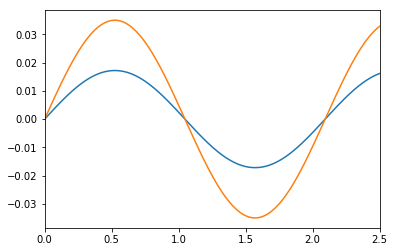

In [5]:
import matplotlib.pyplot as plt

plt.plot((a["x"]+a["ix"])*box/nx,a["vx"])
plt.plot((a["x"]+a["ix"])*box/nx,0.035*np.sin(k*(a["x"]+a["ix"])*box/nx))
plt.xlim([0,2.5])
plt.show()

In [5]:
import os 
origpath=os.getcwd()
if not os.path.exists("warm"):
    os.makedirs("warm")
newpath=origpath+"/warm"
os.chdir(newpath)

# Run the simulation
sim.run( tmax )

os.chdir(origpath)


Running simulation up to t = 50.8 ...
n = 41396, t = 50.8001
Done.


### Checking the results

Select the **field** folder under "warm" using the file explorer

In [3]:
import numpy as np
sys.path.insert(3, '../nb_hlpr')

import tooler
import widg
import visual
from IPython.display import HTML

tab=widg.tabmaker()
tab

By runnig the following cell, you are able to visualize the fourier transform of the E-field, advance it in time using the slider to see the wave being damped !

In [6]:
ylims=[[0,0],[0,0]]
fils=[]
%matplotlib inline
widg.shower(tab,ylims,fils)[0]

interactive(children=(IntSlider(value=0, description='Iteration: ', max=41380, step=20), FloatRangeSlider(valu…

<function visual.pltinteract.<locals>.pltstf(itr, fil, col, fil2=[], col2=None, xlims=None, ylims=None, fils=[], plasm=False)>

And you may also produce a video by runnig the following cell

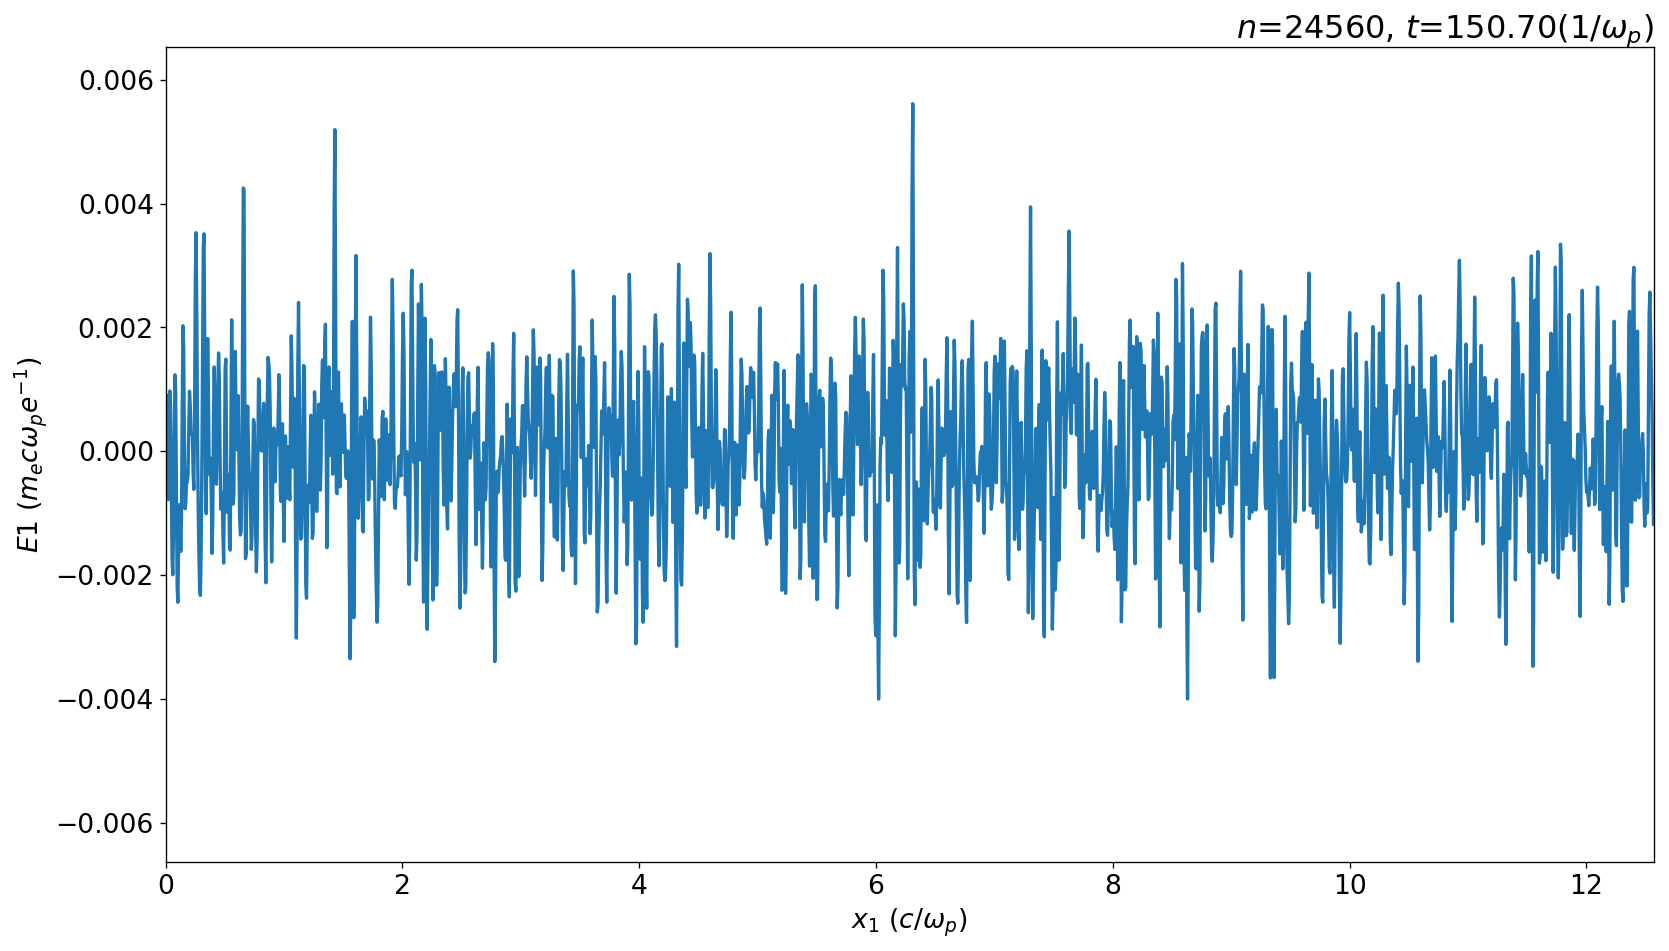

In [27]:
import nb_hlpr.visual as visual
anim=visual.animate(tab,ylims)
anim.save("aa.mp4",fps=24)

##### Damping rate comparision

In [4]:
#compute the derivative of the distribution function
dfdv=-vf/(np.sqrt(2*np.pi)*vth**3)*np.exp(-((vf/vth)**2)/2)
gamma=dfdv*np.pi*wp**3/k**2/2
print("gamma=",gamma)

gamma= -1.2166750701674924e-06


The following tool tracks the amplitude of the wave the specified $k$ in time. You can use it to check if the damping rate matches the theoreticla expectations

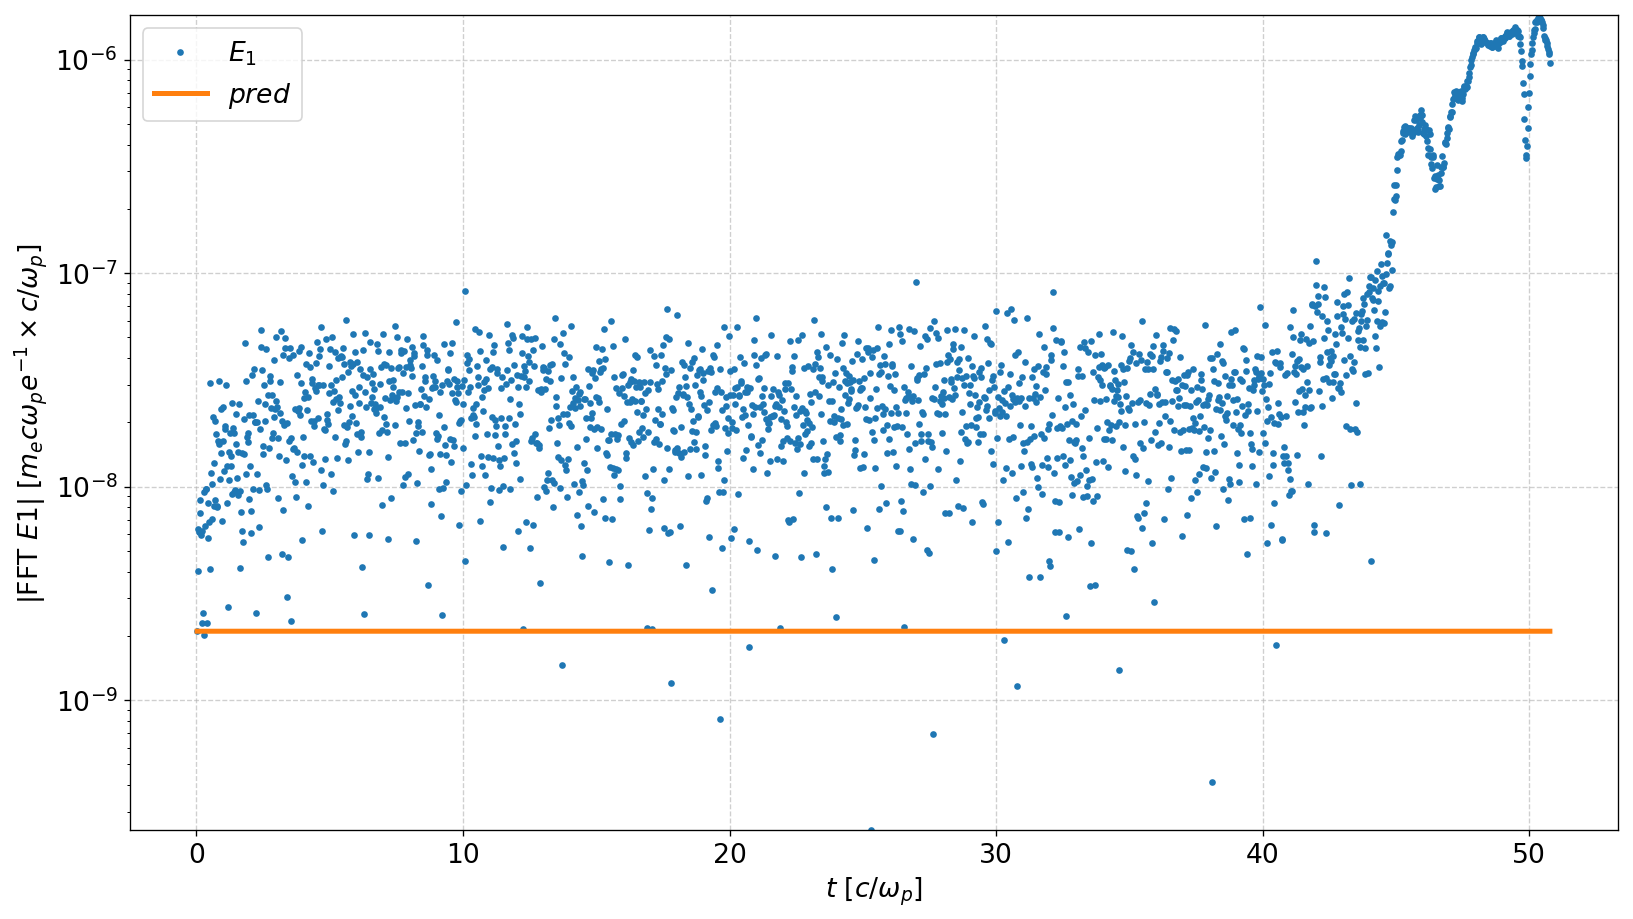

In [5]:
import LdDamp
#widg.damp(k, filechooser,damp rate)
LdDamp.damp(1.,tab,gamma)

##### Particle mixing

As particles exchange energy with the wave, their velocity either increases (if it is initially smaller than $v_\phi$)  or decreases (if it is initially greater than $v_\phi$).

This way, if we track  these particles in phase space we will see that after some time, species
with initially distinct velocities will start getting mixed.

For this reason, we tracked 3 marker species with velocities close to the phase speed: $v_1=0.9v_\phi$, $v_2=v_\phi$, $v_3=1.1v_\phi$ 

You can use the following tool to verify that after some time the different species start to mix

In [6]:
LdDamp.pha_shower(20,"warm/PARTICLES")

interactive(children=(IntSlider(value=0, description='Iteration: ', max=41380, step=20), FloatRangeSlider(valu…

<function LdDamp.pha_shower.<locals>.pltstf(itr, xlims)>

In [9]:
import nb_hlpr.visual as visual
anim=visual.pha_animate(5,"warm/PARTICLES",[0,10])
anim.save("aa8.mp4",fps=60)

### Cold Plasma

If we lower the temperature of the plasma Landau damping will no longer occur as no particles will interact with the wave.
Check this fact by running another simulation 

In [33]:
#insert you value for the wave number
k=5

#insert the desired thermal velocity
vth=0.03

import numpy as np
wp=np.sqrt(2)
vf=np.sqrt(wp**2+3*k**2*vth**2)/k

if vf<3*vth:
    print("v_phase=",vf,"; 3vth=",3*vth,"There will be particles interacting with the wave!")
else:
    print("v_phase=",vf,"; 3vth=",3*vth,"There will not be particles interacting with the wave!")

v_phase= 0.287576076891 ; 3vth= 0.09 There will not be particles interacting with the wave!


In [34]:
import es1d
# Time step
dt = 0.04908699
tmax = 150.8

# Simulation box
nx  = 512
box = 8*np.pi

# Diagnostic frequency
ndump = 5

# Custom density profile for the wave species
def custom_n0(x):
    bx=8*np.pi
    if x<bx:
        return 1.0 + 0.02*np.sin(k*x)
    else:
        return 1

ppc = 1 # Particles per cell
density = es1d.Density( type = es1d.DensityType.custom, custom = custom_n0 )
electrons = es1d.Species( "electrons", -1.0, 1*ppc,density=density)
speclst=[electrons]

#Thermal plasma species
plsm= es1d.Species( "plsm", -1.0, 8*1024*ppc,vth=vth)
speclst.append(plsm)

#marker species with fluid speeds close to the phase pseed o the wave
density2 = es1d.Density( type = es1d.DensityType.uniform )
density2.n=0.0001
marker1= es1d.Species( "marker1", -1.0, 16*ppc,vfl=vf/0.9,density=density2)
speclst.append(marker1)
marker2= es1d.Species( "marker2", -1.0, 16*ppc,vfl=vf,density=density2)
speclst.append(marker2)
marker3= es1d.Species( "marker3", -1.0, 16*ppc,vfl=vf*8/9,density=density2)
speclst.append(marker3)

# Diagnostics
def rep( sim ):
    if ( sim.n % ndump == 0 ):
        marker1.report(es1d.SpeciesDiag.particles)
        marker2.report(es1d.SpeciesDiag.particles)
        marker3.report(es1d.SpeciesDiag.particles)
        # All electric field components
        sim.field.report()
        
# Initialize simulation data
sim = es1d.Simulation( nx, box, dt, speclst,report=rep )

In [35]:
import nb_hlpr.widg as widg
import os
widg.changedir(origpath,"cold")
sim.run(tmax)
widg.changedir(origpath)


Running simulation up to t = 150.8 ...
n = 3073, t = 150.844
Done.


By runnig the following cell, you are able to visualize the fourier transform of the E-field, advance it in time using the slider to see the wave **not** being damped !

In [36]:
import numpy as np
import nb_hlpr.widg as widg
from IPython.display import HTML

tab=widg.tabmaker()
tab

In [41]:
import nb_hlpr.widg as widg
ylims=[[0,0],[0,0]]
fils=[]
%matplotlib inline
widg.FT_shower(tab,ylims,fils)[0]

<function nb_hlpr.visual.FT_pltinteract.<locals>.pltstf>

In [37]:
#compute the derivative of the distribution function
dfdv=-vf/(np.sqrt(2*np.pi)*vth**3)*np.exp(-((vf/vth)**2)/2)
gamma=dfdv*np.pi*wp**3/k**2/2
print("gamma=",gamma)

gamma= -8.40630652538e-18


The following tool tracks the amplitude of the wave the specified $k$ in time. You can use it to check if the damping rate matches the theoreticla expectations

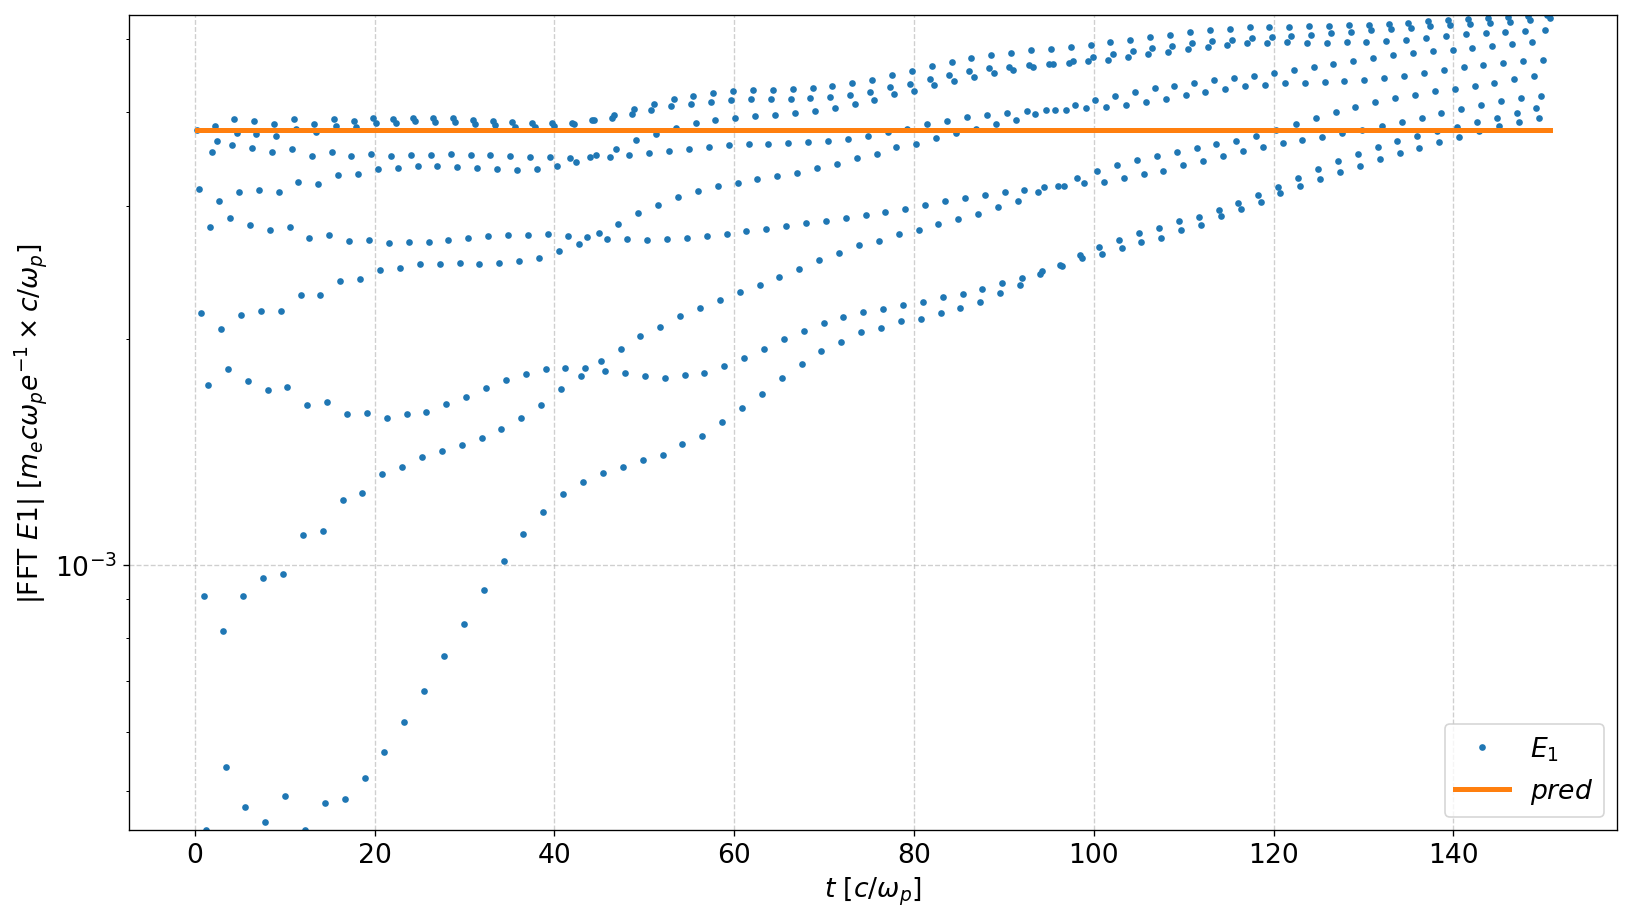

In [40]:
#widg.damp(k, filechooser,damp rate)
widg.damp(5.,tab,gamma)

You can also see the particles **not** mixing

In [42]:
widg.pha_shower(5,"cold/PARTICLES")

<function nb_hlpr.widg.pha_shower.<locals>.pltstf>

### Numerical heating

As shown in the previous section, the wave not damped at start, but its amplitude grows until a point when it starts decaying, this is due to a non-physical phenomenon called **numerical heating**.

It is thourougly explained in pages 158-160 of [3], but in simple terms, it comes from a non-physical force called a *grid force* that appears due to the interpolation of the particles' fields to the grid points.

This effect is attenuated by increasing the number of particles per cell, and is enhanced by decreasing it. This way, if we should see that non physical damping happening earlier

In [43]:
import es1d
# Time step
dt = 0.04908699
tmax = 150.8

# Simulation box
nx  = 512
box = 8*np.pi

# Diagnostic frequency
ndump = 5

# Custom density profile for the wave species
def custom_n0(x):
    bx=8*np.pi
    if x<bx:
        return 1.0 + 0.02*np.sin(k*x)
    else:
        return 1

ppc = 1 # Particles per cell
density = es1d.Density( type = es1d.DensityType.custom, custom = custom_n0 )
electrons = es1d.Species( "electrons", -1.0, 1*ppc,density=density)
speclst=[electrons]

#Thermal plasma species
plsm= es1d.Species( "plsm", -1.0, 64*ppc,vth=vth)
speclst.append(plsm)

#marker species with fluid speeds close to the phase pseed o the wave
density2 = es1d.Density( type = es1d.DensityType.uniform )
density2.n=0.0001
marker1= es1d.Species( "marker1", -1.0, 16*ppc,vfl=vf/0.9,density=density2)
speclst.append(marker1)
marker2= es1d.Species( "marker2", -1.0, 16*ppc,vfl=vf,density=density2)
speclst.append(marker2)
marker3= es1d.Species( "marker3", -1.0, 16*ppc,vfl=vf*8/9,density=density2)
speclst.append(marker3)

# Diagnostics
def rep( sim ):
    if ( sim.n % ndump == 0 ):
        marker1.report(es1d.SpeciesDiag.particles)
        marker2.report(es1d.SpeciesDiag.particles)
        marker3.report(es1d.SpeciesDiag.particles)
        # All electric field components
        sim.field.report()
        
# Initialize simulation data
sim = es1d.Simulation( nx, box, dt, speclst,report=rep )

In [44]:
import nb_hlpr.widg as widg
import os
widg.changedir(origpath,"numcold")
sim.run(tmax)
widg.changedir(origpath)


Running simulation up to t = 150.8 ...
n = 3073, t = 150.844
Done.


In [45]:
import numpy as np
import nb_hlpr.tooler as tooler
import nb_hlpr.widg as widg
import nb_hlpr.visual as visual
from IPython.display import HTML

tab=widg.tabmaker()
tab

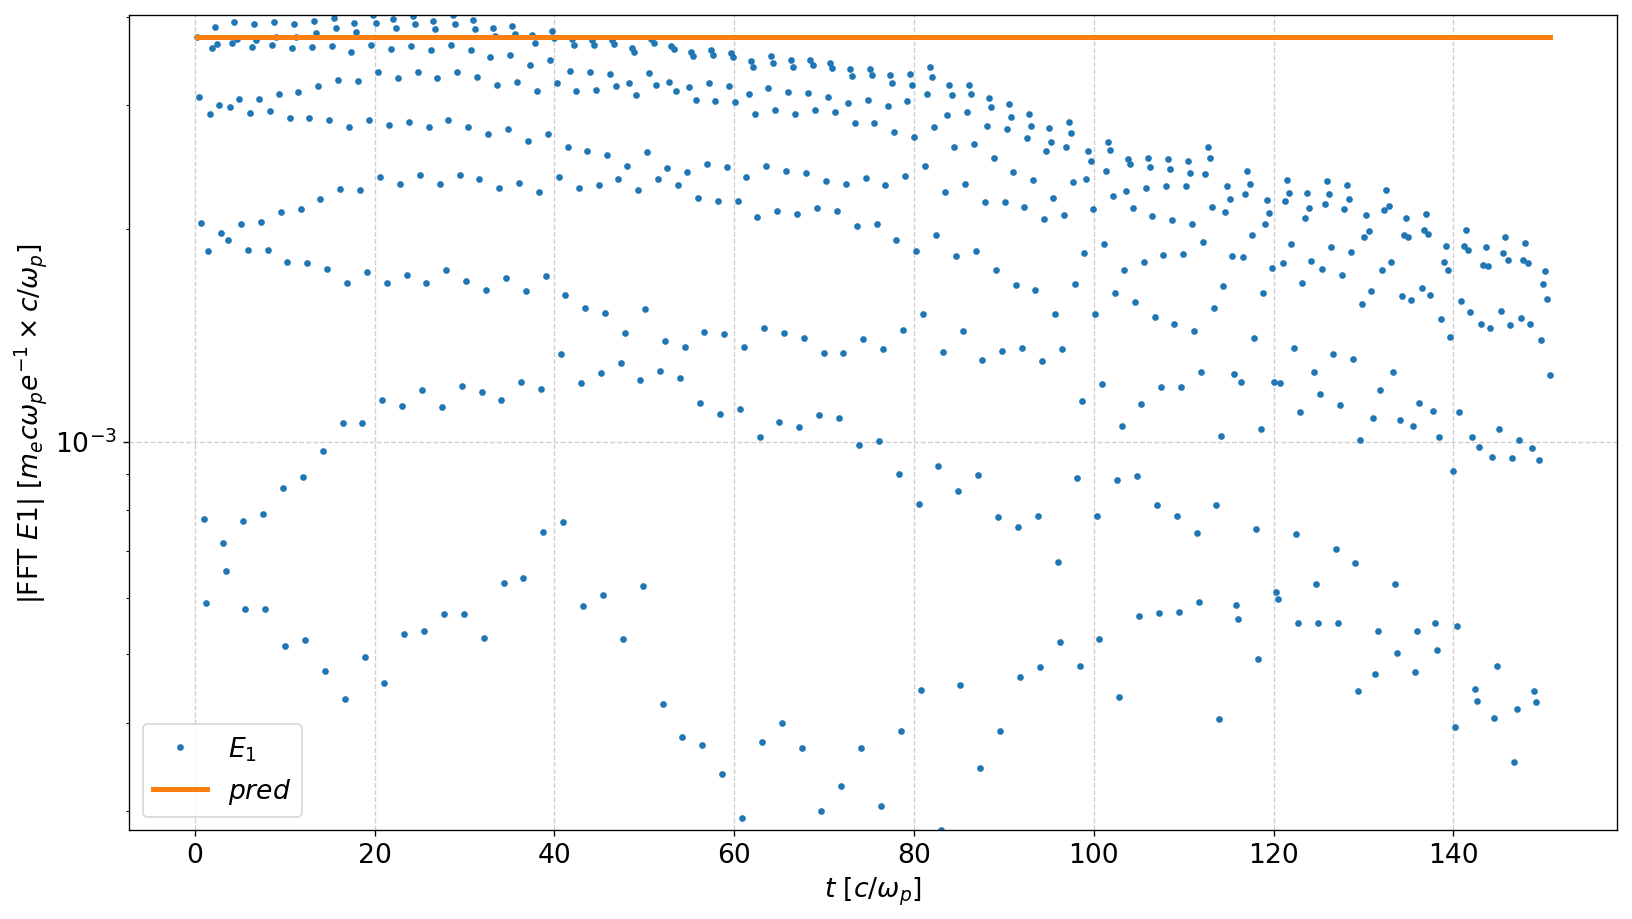

In [46]:
#widg.damp(k, filechooser,damp rate)
widg.damp(5.,tab,gamma)

### Refrences

[1] Jonh D. Jackson. *Classical Electrodynamics*, Wiley, 3rd edition, 1999.

[2] Francis F. Chen. *Introduction to Plasma Physics*, Plenum Press, 2nd edition, 1984

[3] C. K. Birdsall and A. B. Langdon. *Plasma Physics via Computer Simulations*, Adam Hilger, 3rd edition 1991

In [44]:
import numpy as np
vth=0.1
omega=1
k=3

vf1=np.linspace(0,0.5,1024)
dfdv=-vf1/(np.sqrt(2*np.pi)*vth**3)*np.exp(-((vf1/vth)**2)/2)/(vf1*k-omega)

import matplotlib.pyplot as plt
import matplotlib
f=plt.figure(figsize=(14,9))
matplotlib.rcParams.update({'font.size': 22})

plt.plot(vf1,dfdv,lw=4)
plt.ylim([-100,100])
plt.xlim([0,0.45])
plt.grid()
plt.xlabel("v [A.U.]")
plt.ylabel("integrand [A.U.]")

f.savefig("pole.pdf",bbox_inches="tight")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


# 